In [40]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
Compare signal changes in roi between two RTs
fig 3 in the manuscript
@author: yuhui
"""
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import glob
from statsmodels.stats.multitest import multipletests

In [41]:
# Define data directory
data_dir = '/media/yuhui/LCT'

# Define stats prefix and coefficient list
stats_prefix = 'stats3.blur1.rbold.'
coef_list = ['ProbMM valueSH Fs', 'ProbMM valueSH Sl']

# Define ROI list
roi_list = [
    'lc', 'snvta', 'pos_pfc', 'NAc', 'caudate',
    'gray_bridge', 'putamen'
]

In [42]:
roi_num = len(roi_list)
coef_num = len(coef_list)

######################################################
# Initialize results storage
df_results = []
all_roi_data = []
all_roi_sem = []
all_t_stats = []
all_p_vals = []

all_roi_fast_subject = []   # ProbMM valueSH Fs per subject
all_roi_slow_subject = []   # ProbMM valueSH Sl per subject

In [43]:
for roi in roi_list:
    bold_mean_file = f"{stats_prefix}{roi}.1D"
    
    # Define the search pattern
    search_pattern = f"{data_dir}/2*/bold.sft/roiProfile/{bold_mean_file}"

    # Find all matching files
    bold_subj_list = sorted(glob.glob(search_pattern))
    
    subj_num = len(bold_subj_list)
    
    if subj_num > 0:
        roi_mean_all = np.zeros((coef_num, subj_num))
        
        for subj_idx, subj_file in enumerate(bold_subj_list):
            roi_mean_all[:, subj_idx] = np.loadtxt(subj_file)
        
        roi_mean = np.mean(roi_mean_all, axis=1)
        roi_sem = np.std(roi_mean_all, axis=1) / np.sqrt(subj_num)

        # roi_mean_all shape: (2, subj_num) with rows [Fs, Sl]
        all_roi_fast_subject.append(roi_mean_all[0, :].copy())  # NEW
        all_roi_slow_subject.append(roi_mean_all[1, :].copy())  # NEW

        # Store ROI data for combined plot
        all_roi_data.append(roi_mean)
        all_roi_sem.append(roi_sem)
        
        # Perform paired t-tests for last two coefficients
        data1, data2 = roi_mean_all[-2, :], roi_mean_all[-1, :]
        t_stat, p_val = stats.ttest_rel(data1, data2)
        
        diff = data1 - data2
        cohen_d = np.mean(diff) / np.std(diff, ddof=1)
        df = subj_num-1
        
        df_results.append([roi, t_stat, p_val, cohen_d, df])
        all_t_stats.append(t_stat)
        all_p_vals.append(p_val)

# Convert results to DataFrame
df_results = pd.DataFrame(df_results, columns=['ROI', 't_value', 'p_value', 'Cohen_d', 'df'])

# Apply FDR correction (Benjamini-Hochberg)
p_vals_array = np.array(all_p_vals)  # Convert p-values to array
_, p_vals_corrected, _, _ = multipletests(p_vals_array, alpha=0.05, method='fdr_bh')

df_results["p_value_corrected"] = p_vals_corrected
print(df_results)

# Convert all ROI data to a NumPy array for plotting
all_roi_data = np.array(all_roi_data)
all_roi_sem = np.array(all_roi_sem)
all_t_stats = np.array(all_t_stats)
all_p_vals = np.array(all_p_vals)

           ROI   t_value   p_value   Cohen_d  df  p_value_corrected
0           lc  0.910391  0.374022  0.203570  19           0.436359
1        snvta -1.505827  0.148556 -0.336713  19           0.346631
2      pos_pfc  1.229709  0.233816  0.274971  19           0.382679
3          NAc  0.032344  0.974535  0.007232  19           0.974535
4      caudate  1.128050  0.273342  0.252240  19           0.382679
5  gray_bridge  3.167155  0.005074  0.708197  19           0.035518
6      putamen  2.342451  0.030198  0.523788  19           0.105695


++ save fig to the server


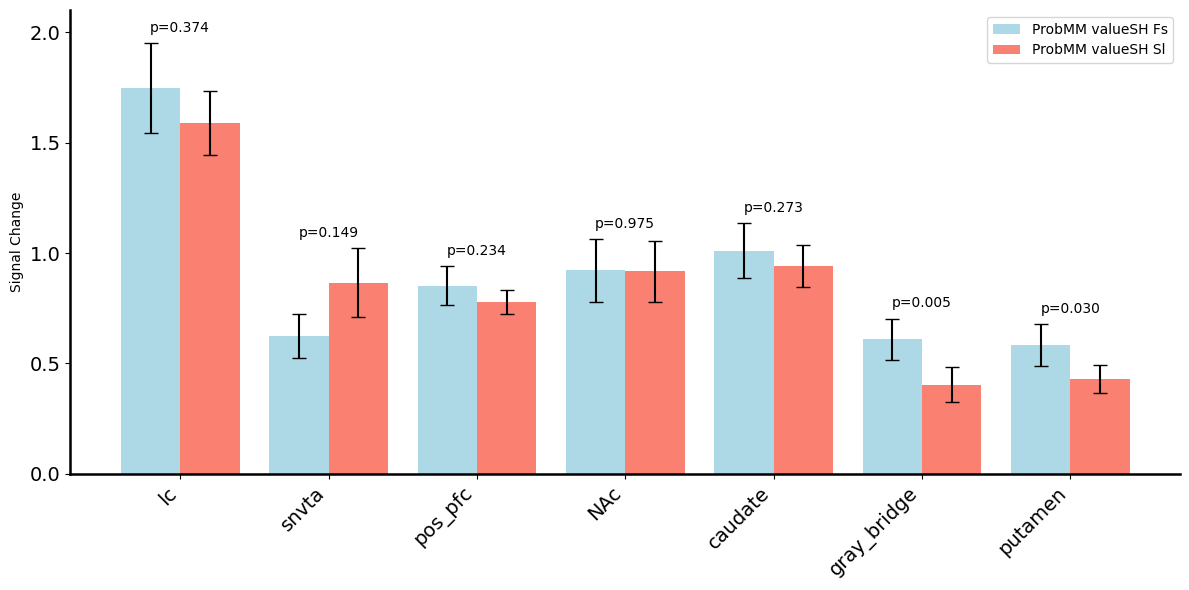

In [45]:
######################################################
# Combined Bar Plot for All ROIs with Error Bars
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))  # X-axis positions
width = 0.4  # Bar width

# Plot each coefficient as a paired bar with error bars
bars1 = ax.bar(x - width/2, all_roi_data[:, 0], width, label=coef_list[0],
               color='lightblue', yerr=all_roi_sem[:, 0], capsize=5)
bars2 = ax.bar(x + width/2, all_roi_data[:, 1], width, label=coef_list[1],
               color='salmon', yerr=all_roi_sem[:, 1], capsize=5)
# Set Y-axis limit to accommodate text annotations
max_y = np.max(all_roi_data + all_roi_sem)+0.15
ax.set_ylim(0, max_y)
# Annotate t-values and p-values above each pair of bars
# t={all_t_stats[i]:.2f}, 
for i in range(len(roi_list)):
    ax.text(x[i], max(all_roi_data[i]) + max(all_roi_sem[i]) + 0.05, 
            f"p={all_p_vals[i]:.3f}", 
            ha='center', fontsize=10, color='black')

ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
# ax.set_title("Mean Signal Change Across ROIs with Error Bars")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)  
ax.spines['bottom'].set_linewidth(1.8)
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(5))  # Limits to 5 ticks on y-axis
# # ax.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()
plt.tight_layout()
plt.savefig("output/roi_rt.png", dpi=300, bbox_inches='tight')
print("++ save fig to the server")

++ saved output/roi_rt_violin_slope.png


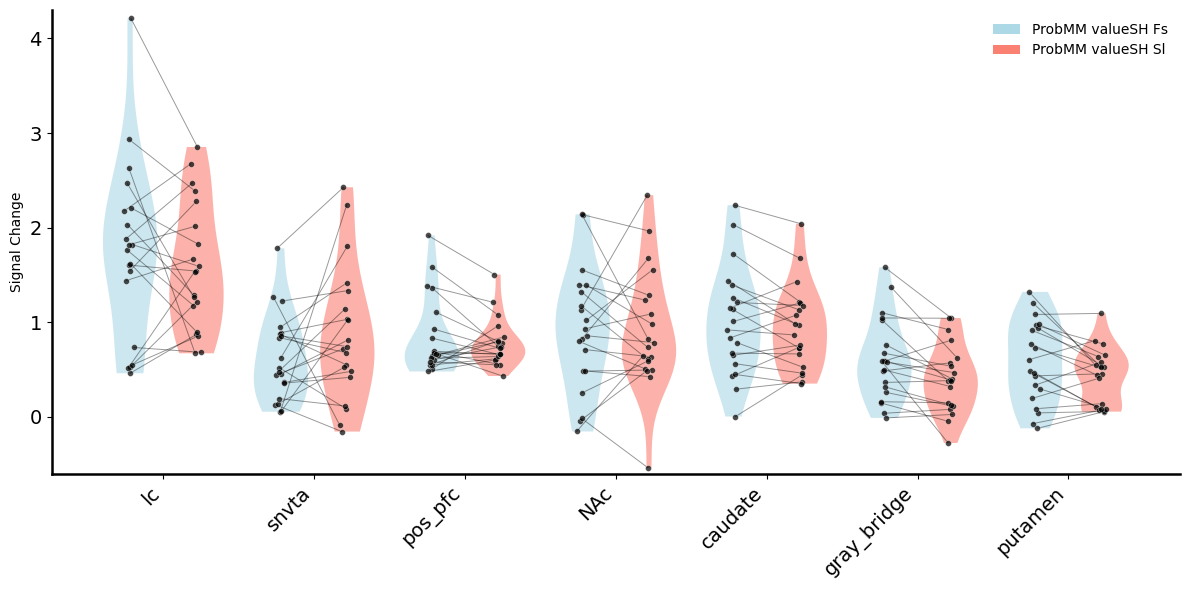

In [69]:
# %% Violin + paired slope (Fast → Slow) for all ROIs (Fig 3 RT effect)
import numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))
offset   = 0.22        # half-distance between Fast and Slow per ROI
vwidth   = 0.36
JITTER_SD = 0.02
rng = np.random.default_rng(7)

fast_color, slow_color = 'lightblue', 'salmon'
FAST_LABEL, SLOW_LABEL = coef_list[0], coef_list[1]

# match your bar plot scale
max_y = np.max(all_roi_data + all_roi_sem) + 0.15
ax.set_ylim(-0.6, 4.3)

for i in range(len(roi_list)):
    fast = np.asarray(all_roi_fast_subject[i], float)   # Fs
    slow = np.asarray(all_roi_slow_subject[i], float)   # Sl

    # violins (background)
    parts = ax.violinplot([fast, slow],
                          positions=[x[i]-offset, x[i]+offset],
                          widths=vwidth,
                          showmeans=False, showmedians=False, showextrema=False)
    parts['bodies'][0].set_facecolor(fast_color); parts['bodies'][0].set_alpha(0.6); parts['bodies'][0].set_edgecolor('none')
    parts['bodies'][1].set_facecolor(slow_color); parts['bodies'][1].set_alpha(0.6); parts['bodies'][1].set_edgecolor('none')

    # paired slope lines + points (same jitter on both ends per subject)
    mask = np.isfinite(fast) & np.isfinite(slow)
    fast, slow = fast[mask], slow[mask]
    base = rng.normal(0, JITTER_SD, size=fast.size)
    x_fast = x[i] - offset + base
    x_slow = x[i] + offset + base

    # lines (under dots)
    for xf, xs, yf, ys in zip(x_fast, x_slow, fast, slow):
        ax.plot([xf, xs], [yf, ys], color='k', alpha=0.4, lw=0.7, zorder=4)

    # dots
    ax.scatter(x_fast, fast, s=18, alpha=0.7, color='k', linewidth=0.3, edgecolor='white', zorder=5)
    ax.scatter(x_slow, slow, s=18, alpha=0.7, color='k', linewidth=0.3, edgecolor='white', zorder=5)

ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
ax.tick_params(axis='y', labelsize=14); ax.tick_params(axis='x', labelsize=14)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8); ax.spines['bottom'].set_linewidth(1.8)
ax.legend(handles=[Patch(facecolor=fast_color, label=FAST_LABEL),
                   Patch(facecolor=slow_color, label=SLOW_LABEL)],
          frameon=False, loc='upper right')

plt.tight_layout()
plt.savefig("output/roi_rt_violin_slope.png", dpi=300, bbox_inches='tight')
print("++ saved output/roi_rt_violin_slope.png")